# SNR Experiment Runner

This notebook orchestrates the eight-case SNR experiment for PRISMA and EnMAP scenes using the consolidated CLI entry point `scripts.snr_experiment`. Each run generates striping diagnostics, PCA visualisations, and per-case CSV/PNG outputs inside `notebooks/outputs/<sensor>/<scene_id>/`.

## Prerequisites

- Install the Python dependencies required by the SNR workflow (`numpy`, `scipy`, `scikit-learn`, `matplotlib`, `scikit-image` if you want Sobel-based masks).
- Ensure PRISMA `.he5`/`.zip` files or EnMAP VNIR/SWIR GeoTIFFs and `METADATA.XML` are accessible from this repository.
- Adjust the scene configuration below to point to your local datasets (ROIs and band windows are optional).

In [6]:
import os
import sys
import subprocess
from pathlib import Path
from datetime import datetime
from typing import Iterable, Optional

from IPython.display import Markdown, display

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT
while not (REPO_ROOT / "scripts").exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent
if not (REPO_ROOT / "scripts").exists():
    raise RuntimeError("Could not locate repository root containing scripts directory.")
os.environ["PYTHONPATH"] = str(REPO_ROOT)
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
PYTHON = sys.executable
DEFAULT_OUTDIR = NOTEBOOK_ROOT / 'outputs'
DEFAULT_OUTDIR.mkdir(parents=True, exist_ok=True)


display(Markdown(
    f"**Notebook root**: `{REPO_ROOT}`  \
     **Python**: `{PYTHON}`  \
     **PYTHONPATH**: `{os.environ['PYTHONPATH']}`"
))

**Notebook root**: `/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas`       **Python**: `/home/esivla/miniconda3/envs/hygasMF/bin/python`       **PYTHONPATH**: `/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas`

In [7]:
def run_snr_experiment(
    sensor: str,
    inputs: Iterable[str],
    roi: Optional[str] = None,
    bands: Optional[str] = None,
    cases: Optional[str] = None,
    disable_notch: bool = False,
    extra_args: Optional[Iterable[str]] = None,
    outdir: Optional[str] = None,
):
    """Invoke the CLI for a single scene and return the completed process."""

    target_outdir = Path(outdir) if outdir else DEFAULT_OUTDIR
    target_outdir.mkdir(parents=True, exist_ok=True)

    cmd = [
        PYTHON,
        "-m",
        "scripts.snr_experiment",
        "--sensor",
        sensor,
        "--input",
    ]
    cmd.extend(str(path) for path in inputs)
    if roi:
        cmd.extend(["--roi", roi])
    if bands:
        cmd.extend(["--bands", bands])
    if cases:
        cmd.extend(["--cases", cases])
    if disable_notch:
        cmd.append("--disable-notch")
    cmd.extend(["--outdir", str(target_outdir)])
    if extra_args:
        cmd.extend(str(arg) for arg in extra_args)

    display(Markdown(f"**Running**: `{' '.join(cmd)}`"))
    start = datetime.now()
    result = subprocess.run(cmd, capture_output=True, text=True, env=os.environ.copy())
    duration = datetime.now() - start
    status = "success" if result.returncode == 0 else f"failed (code {result.returncode})"

    display(Markdown(f"- Status: **{status}** in {duration.total_seconds():.1f}s"))
    if result.stdout:
        display(Markdown(f"<details><summary>stdout</summary><pre>{result.stdout}</pre></details>"))
    if result.stderr:
        display(Markdown(f"<details><summary>stderr</summary><pre>{result.stderr}</pre></details>"))

    return result


## Outputs and Interpretation

Running a scene produces `outputs/prisma/<scene_id>/` with several diagnostics:
- **striping_diagnostics.png** – compares plain vs destriped radiance for a representative band.
  - Spatial maps (top) should reveal fewer stripes after processing.
  - Column mean/σ plots (middle) show how equalisation affects column statistics; flatter curves and lower σ indicate success.
  - The FFT panel (bottom) highlights stripe frequencies; a smaller peak means coherent striping was damped.
- **pca_summary_plain.png** and **pca_summary_destriped.png** – PCA breakdown of the cube before/after destriping.
  - Use the explained variance and component spectra to ensure signal structure is preserved.
  - Residual maps (SWIR/VNIR) and spectra reveal whether destriping reduced structured noise.
- **snr_cases_*.csv** – numeric SNR curves for cases A–H. Key columns:
  - `mu`: mean radiance used for SNR, `sigma`: noise estimate (total or random).
  - `snr_median` / `snr_p90`: column-median and 90th percentile SNR for columnwise cases (equal to ROI SNR when `aggregation=roi`).
  - `case`, `sigma_type`, `aggregation` document how the metric was computed.
- **snr_cases_overview.png** – grid of cases A–H for quick comparison between plain/destriped and ROI/columnwise modes.

### How to interpret the results
- Start with the striping diagnostic to verify that destriping reduces column oscillations without creating artefacts.
- Review the PCA summaries to confirm residuals become less structured and that principal components remain physically plausible.
- Compare SNR CSVs or the overview plot: destriping should narrow the gap between ROI and columnwise curves without depressing absolute SNR.
- If you disable equalisation (`--disable-equalize`) or the notch, expect the corresponding panels to look similar – a useful sanity check.


## Configure Scenes

Each configuration dictionary is passed directly to `run_snr_experiment`.
Use `extra_args` to tune destriping:

- `--equalize-scale-strength <0-1>`: blend toward column MAD scaling (0 = offsets only, default 0.3).
- `--equalize-scale-cap <>=1>`: limits gain adjustment per column (default 1.5).
- `--equalize-poly-order <int>`: polynomial order (>=0) removed per column (default 2, -1 disables).
- `--disable-equalize`: bypass per-column equalisation (only the notch, if enabled, runs).
- `--disable-notch`: skip the FFT notch if you only want equalisation.

Hints for optimisation:
- Start with offsets only: set `--equalize-scale-strength 0` and review `striping_diagnostics.png` (column σ should drop without roughening the image).
- If a residual gain striping remains, increase strength gradually (e.g. 0.1 → 0.3) and limit `scale-cap` to ~1.5.
- Lower polynomial order (1) if trends are nearly linear; use `-1` to skip trend removal when scenes already look flat.
- Compare SNR cases F/H (columnwise) before/after tweaks—the median/P90 gap should shrink without depressing absolute SNR.

Below is an example Prisma configuration; uncomment and adjust paths/parameters as needed.

For manual tuning, typical ranges are: scale-strength 0.0–0.3, scale-cap 1.0–1.5, poly-order 0–2. Start low and increase gradually.


In [8]:
SCENE_CONFIGS = [
    #Example:
    {
        "sensor": "prisma",
        "inputs": [
            "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip",
            "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip",
        ],
        #"roi": "100:400,50:350",  # optional
        "bands": "1000:2500",      # optional spectral window in nm
        "cases": "A,B,C,D,E,F,G,H",
        # add destriping tuning here, e.g.
        "extra_args": [
            "--mask-frac", "1",
            "--diff-axis", "columns",
            "--k-pca", "4",
            #"--disable-equalize",
            "--equalize-scale-strength", "0.5",
            "--equalize-scale-cap", "1.5",
            "--equalize-poly-order", "1",
        ],
        "disable_notch": True,
    },
]
SCENE_CONFIGS

[{'sensor': 'prisma',
  'inputs': ['/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip',
   '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip'],
  'bands': '1000:2500',
  'cases': 'A,B,C,D,E,F,G,H',
  'extra_args': ['--mask-frac',
   '1',
   '--diff-axis',
   'columns',
   '--k-pca',
   '4',
   '--equalize-scale-strength',
   '0.5',
   '--equalize-scale-cap',
   '1.5',
   '--equalize-poly-order',
   '1'],
  'disable_notch': True}]

## Run Experiments

In [9]:
results = []
for cfg in SCENE_CONFIGS:
    result = run_snr_experiment(**cfg)
    results.append((cfg, result))
    if result.returncode != 0:
        break

results

**Running**: `/home/esivla/miniconda3/envs/hygasMF/bin/python -m scripts.snr_experiment --sensor prisma --input /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip --bands 1000:2500 --cases A,B,C,D,E,F,G,H --disable-notch --outdir /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs --mask-frac 1 --diff-axis columns --k-pca 4 --equalize-scale-strength 0.5 --equalize-scale-cap 1.5 --equalize-poly-order 1`

- Status: **success** in 189.6s

<details><summary>stdout</summary><pre>Sun Zenith Angle (degrees): 25.568771
SNR experiment completed. Outputs stored in /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/prisma/20200401085313
</pre></details>

<details><summary>stderr</summary><pre>/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/scripts/diagnostics/plots.py:21: RuntimeWarning: Mean of empty slice
  col_mean = np.nanmean(values, axis=0)
/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
</pre></details>

[({'sensor': 'prisma',
   'inputs': ['/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip',
    '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip'],
   'bands': '1000:2500',
   'cases': 'A,B,C,D,E,F,G,H',
   'extra_args': ['--mask-frac',
    '1',
    '--diff-axis',
    'columns',
    '--k-pca',
    '4',
    '--equalize-scale-strength',
    '0.5',
    '--equalize-scale-cap',
    '1.5',
    '--equalize-poly-order',
    '1'],
   'disable_notch': True},
  CompletedProcess(args=['/home/esivla/miniconda3/envs/hygasMF/bin/python', '-m', 'scripts.snr_experiment', '--sensor', 'prisma', '--input', '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection

## Inspect Outputs

The cell below searches the output directory for generated CSVs and PNGs so that you can quickly inspect the latest results.

Found 8 CSV files, 1 SNR overview plots, 1 striping diagnostics, and 2 PCA summaries.

#### SNR overview

**20200401085313 / snr_cases_overview.png**

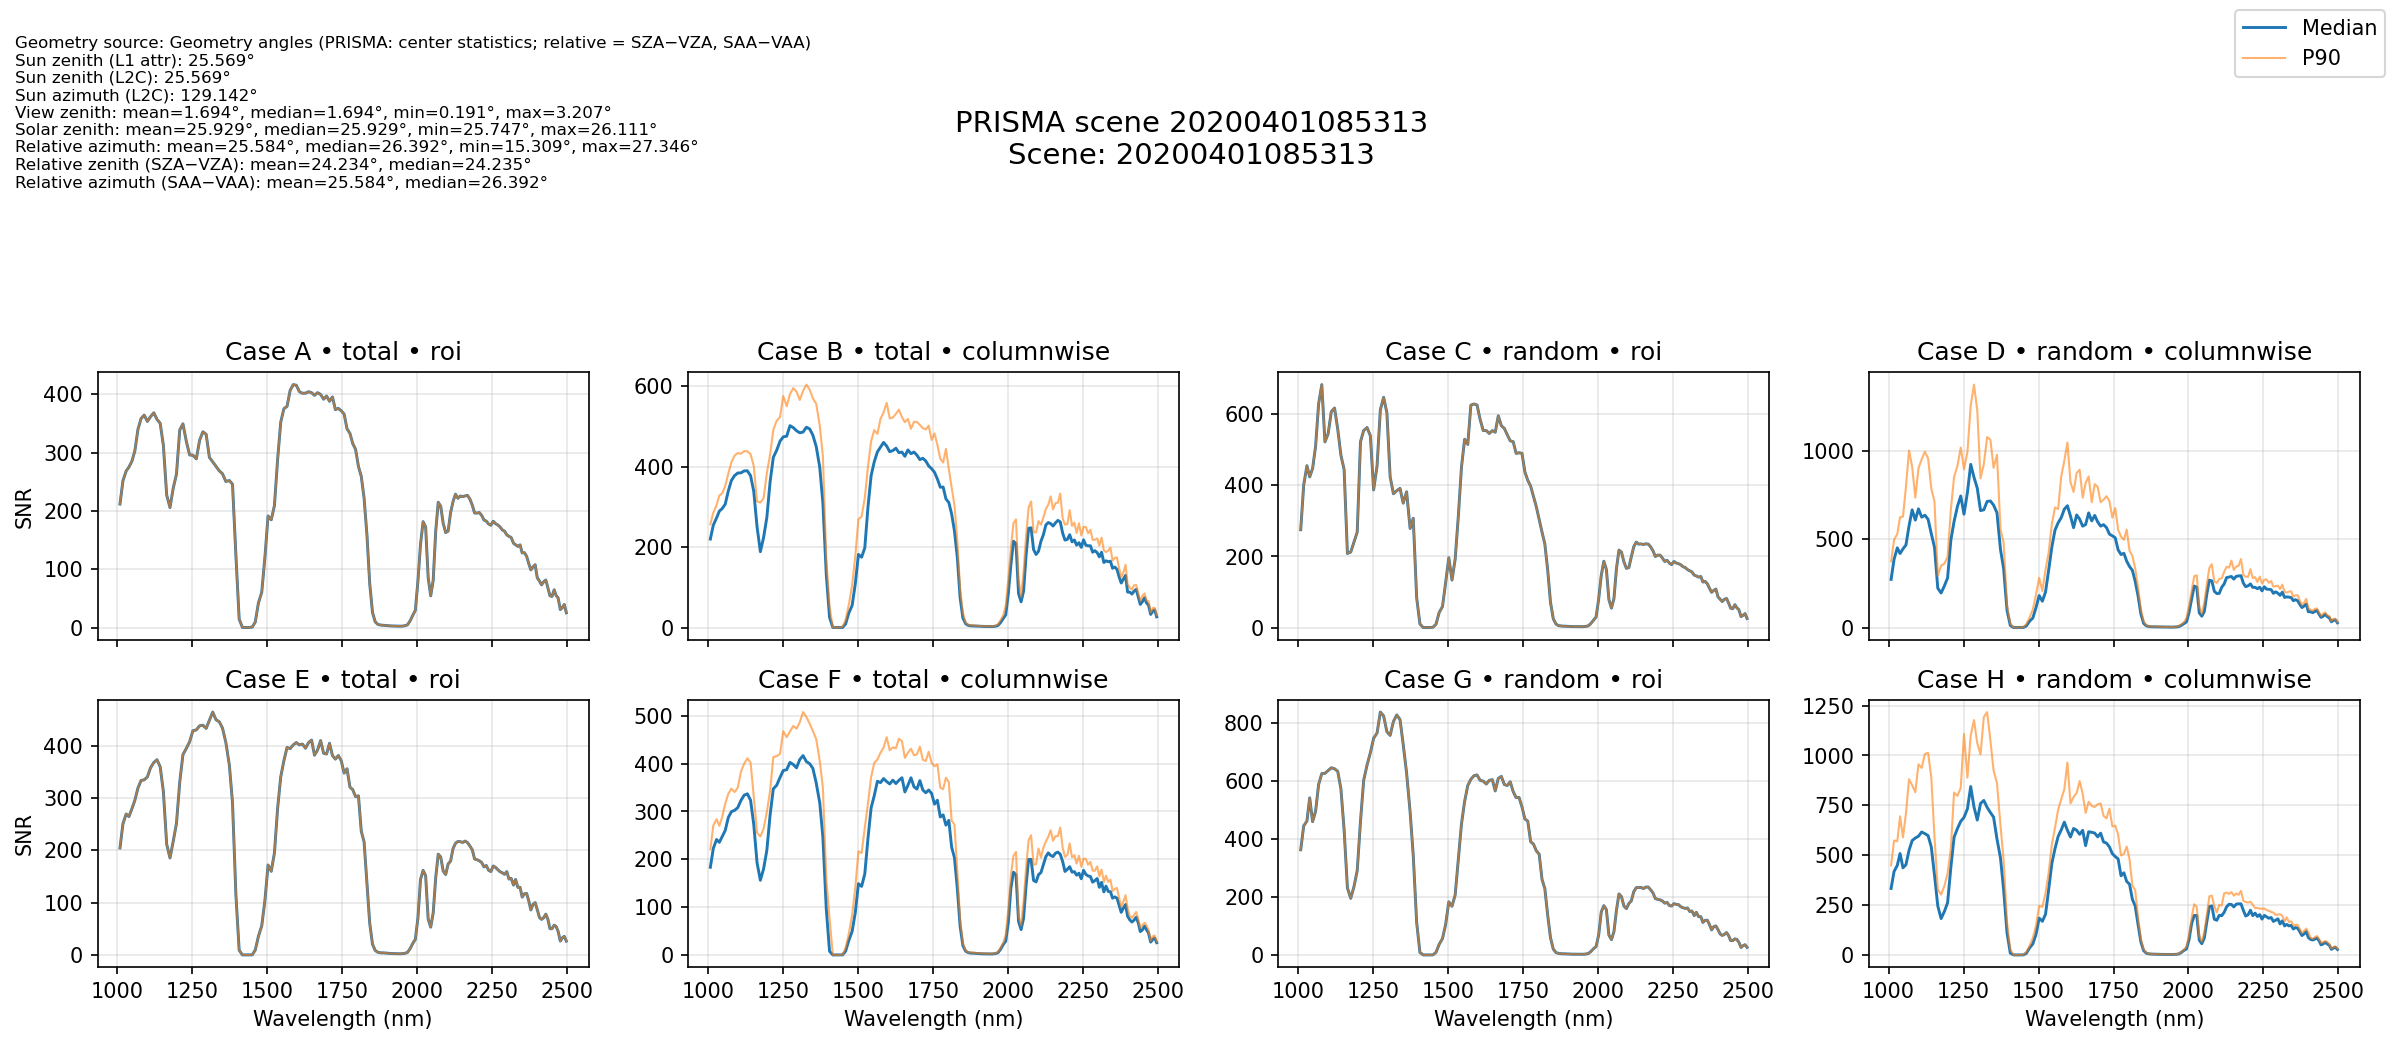

#### Striping diagnostics

**20200401085313 / striping_diagnostics.png**

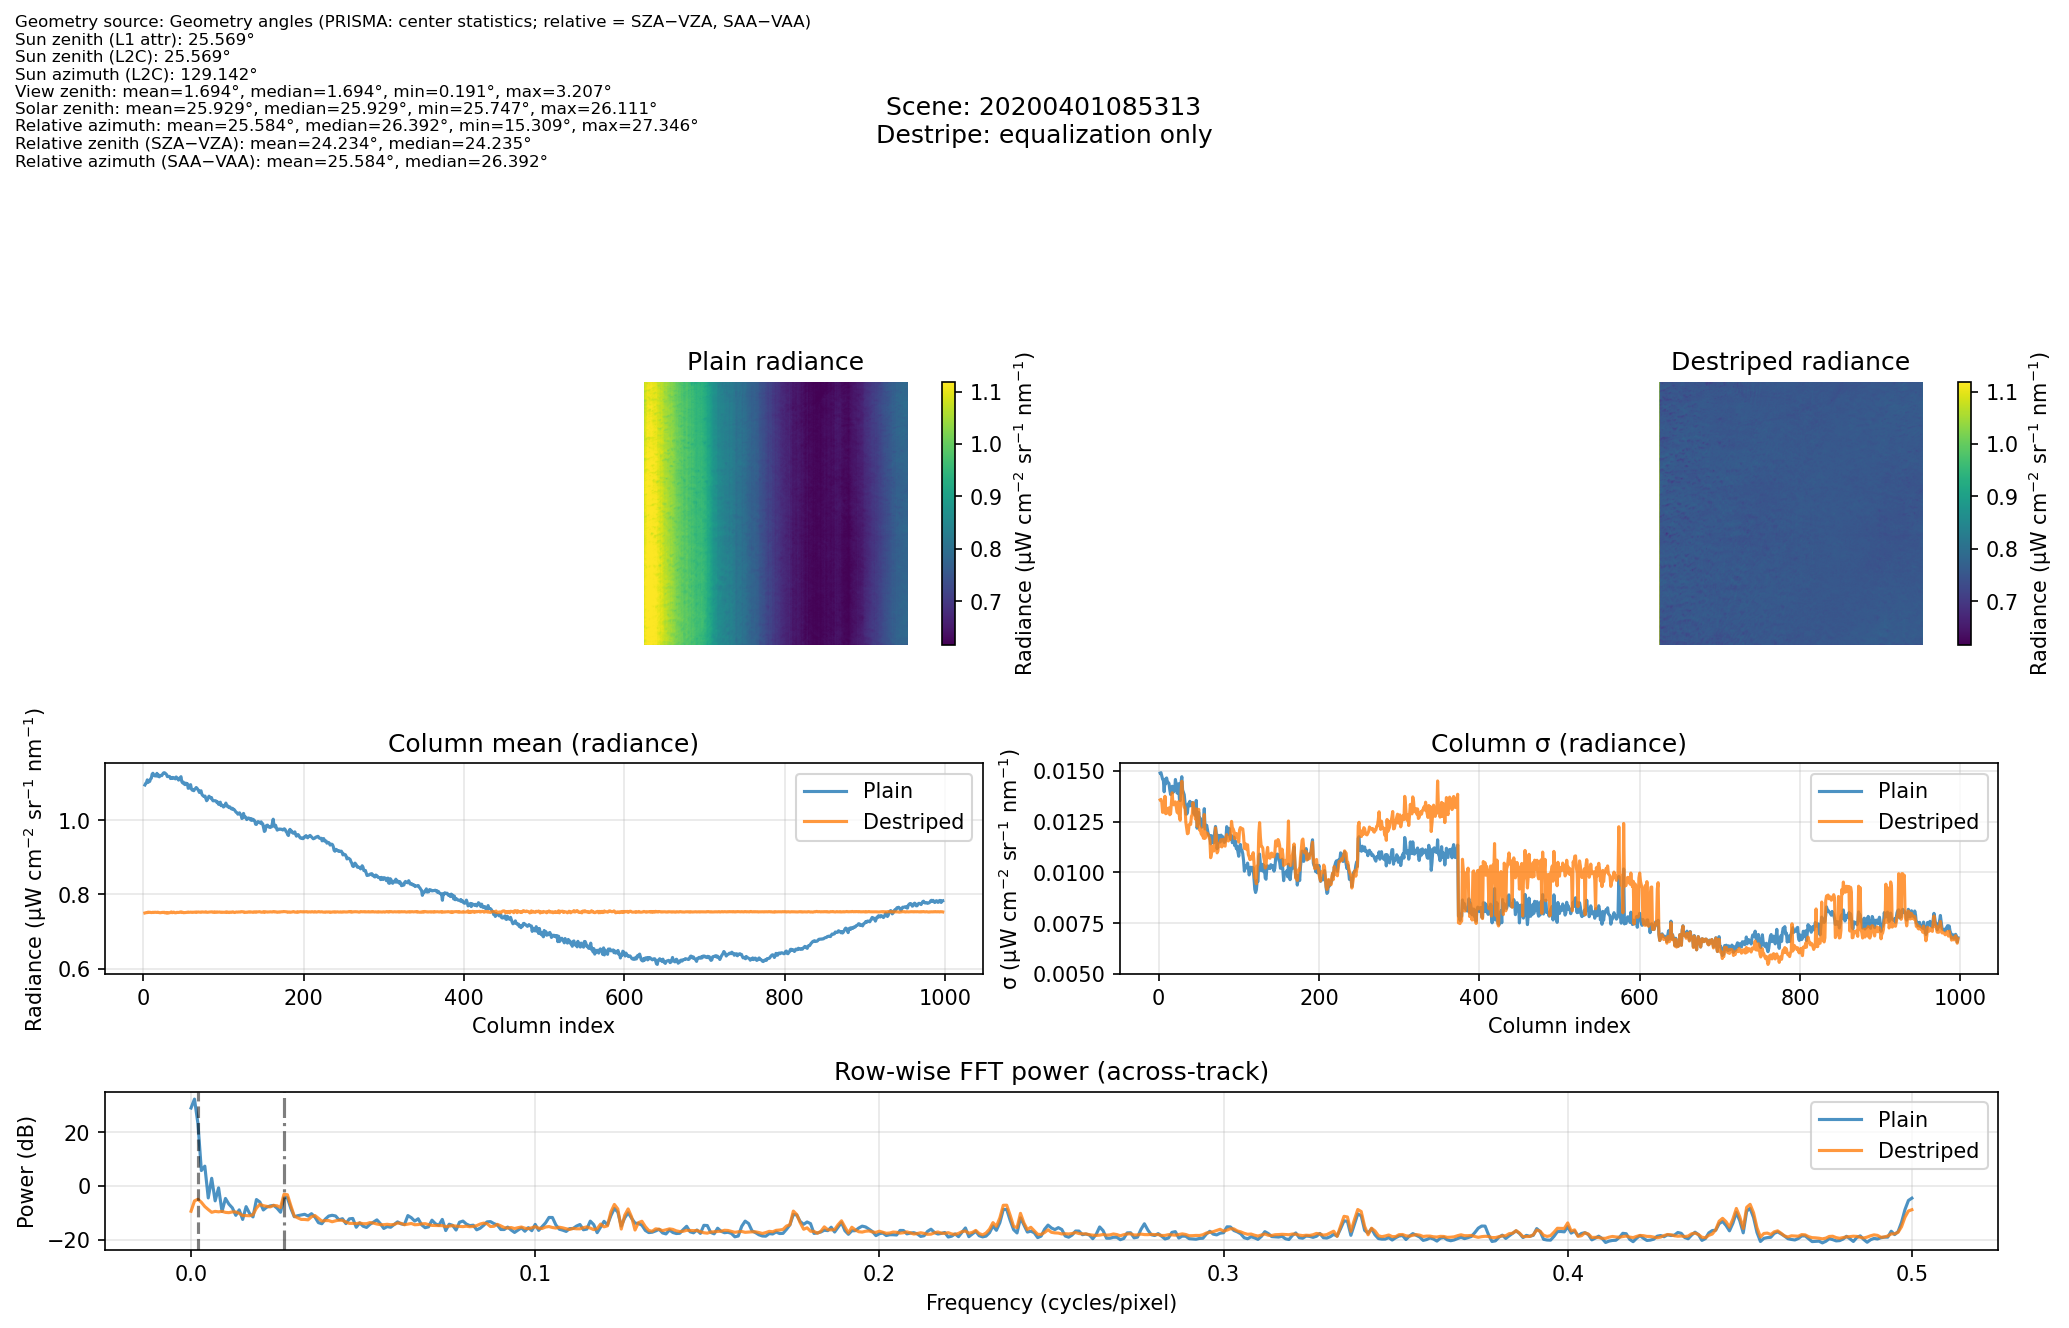

#### PCA summaries

**20200401085313 / pca_summary_destriped.png**

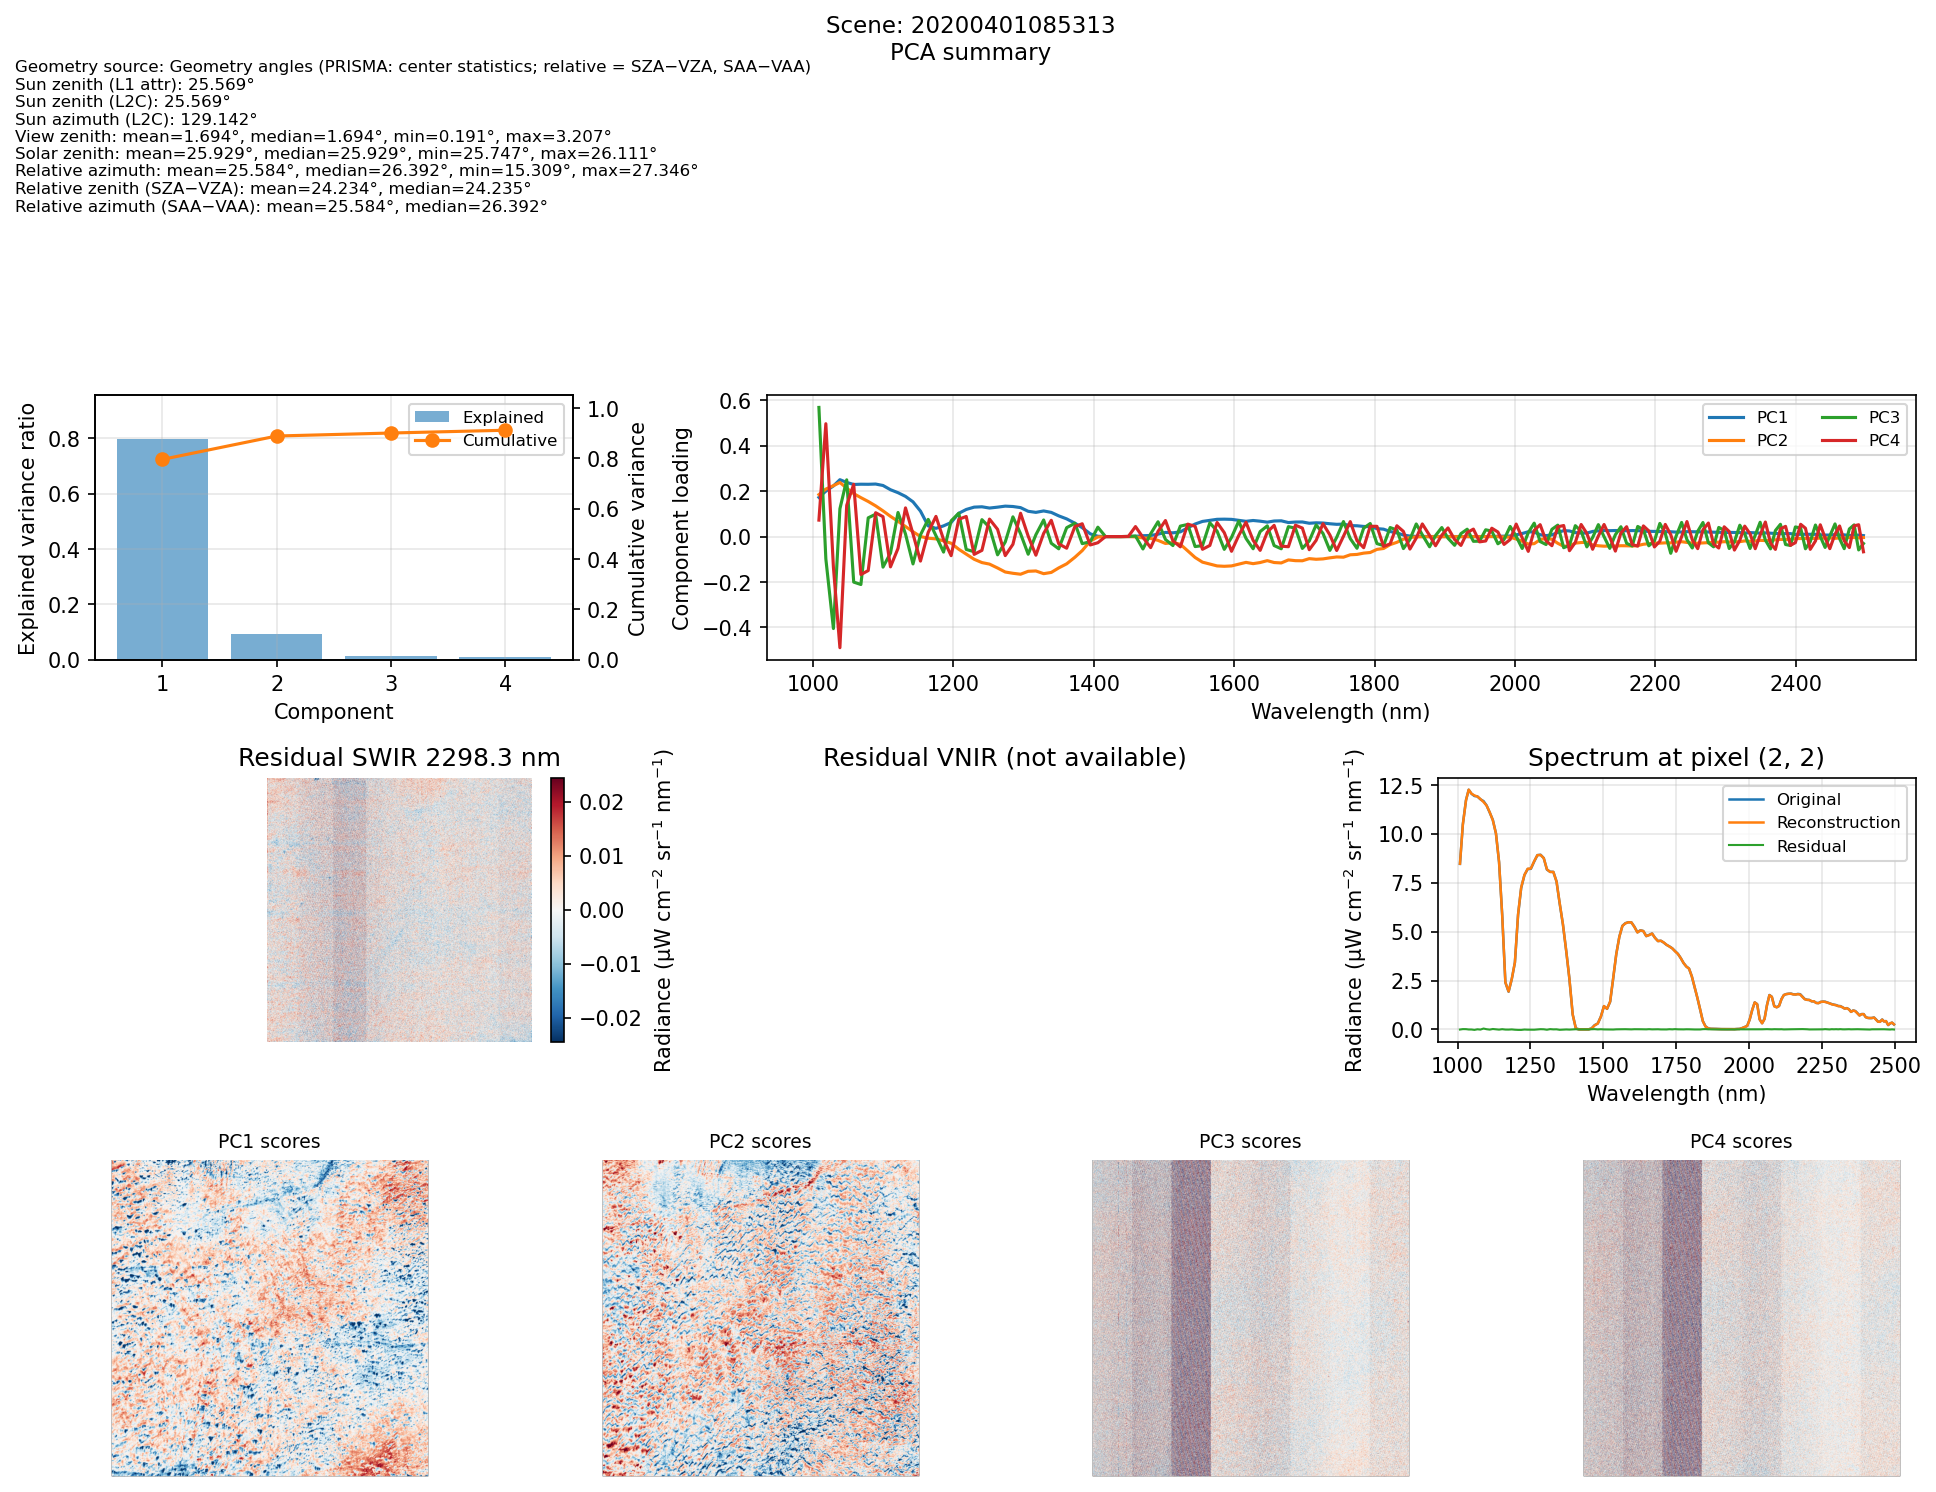

**20200401085313 / pca_summary_plain.png**

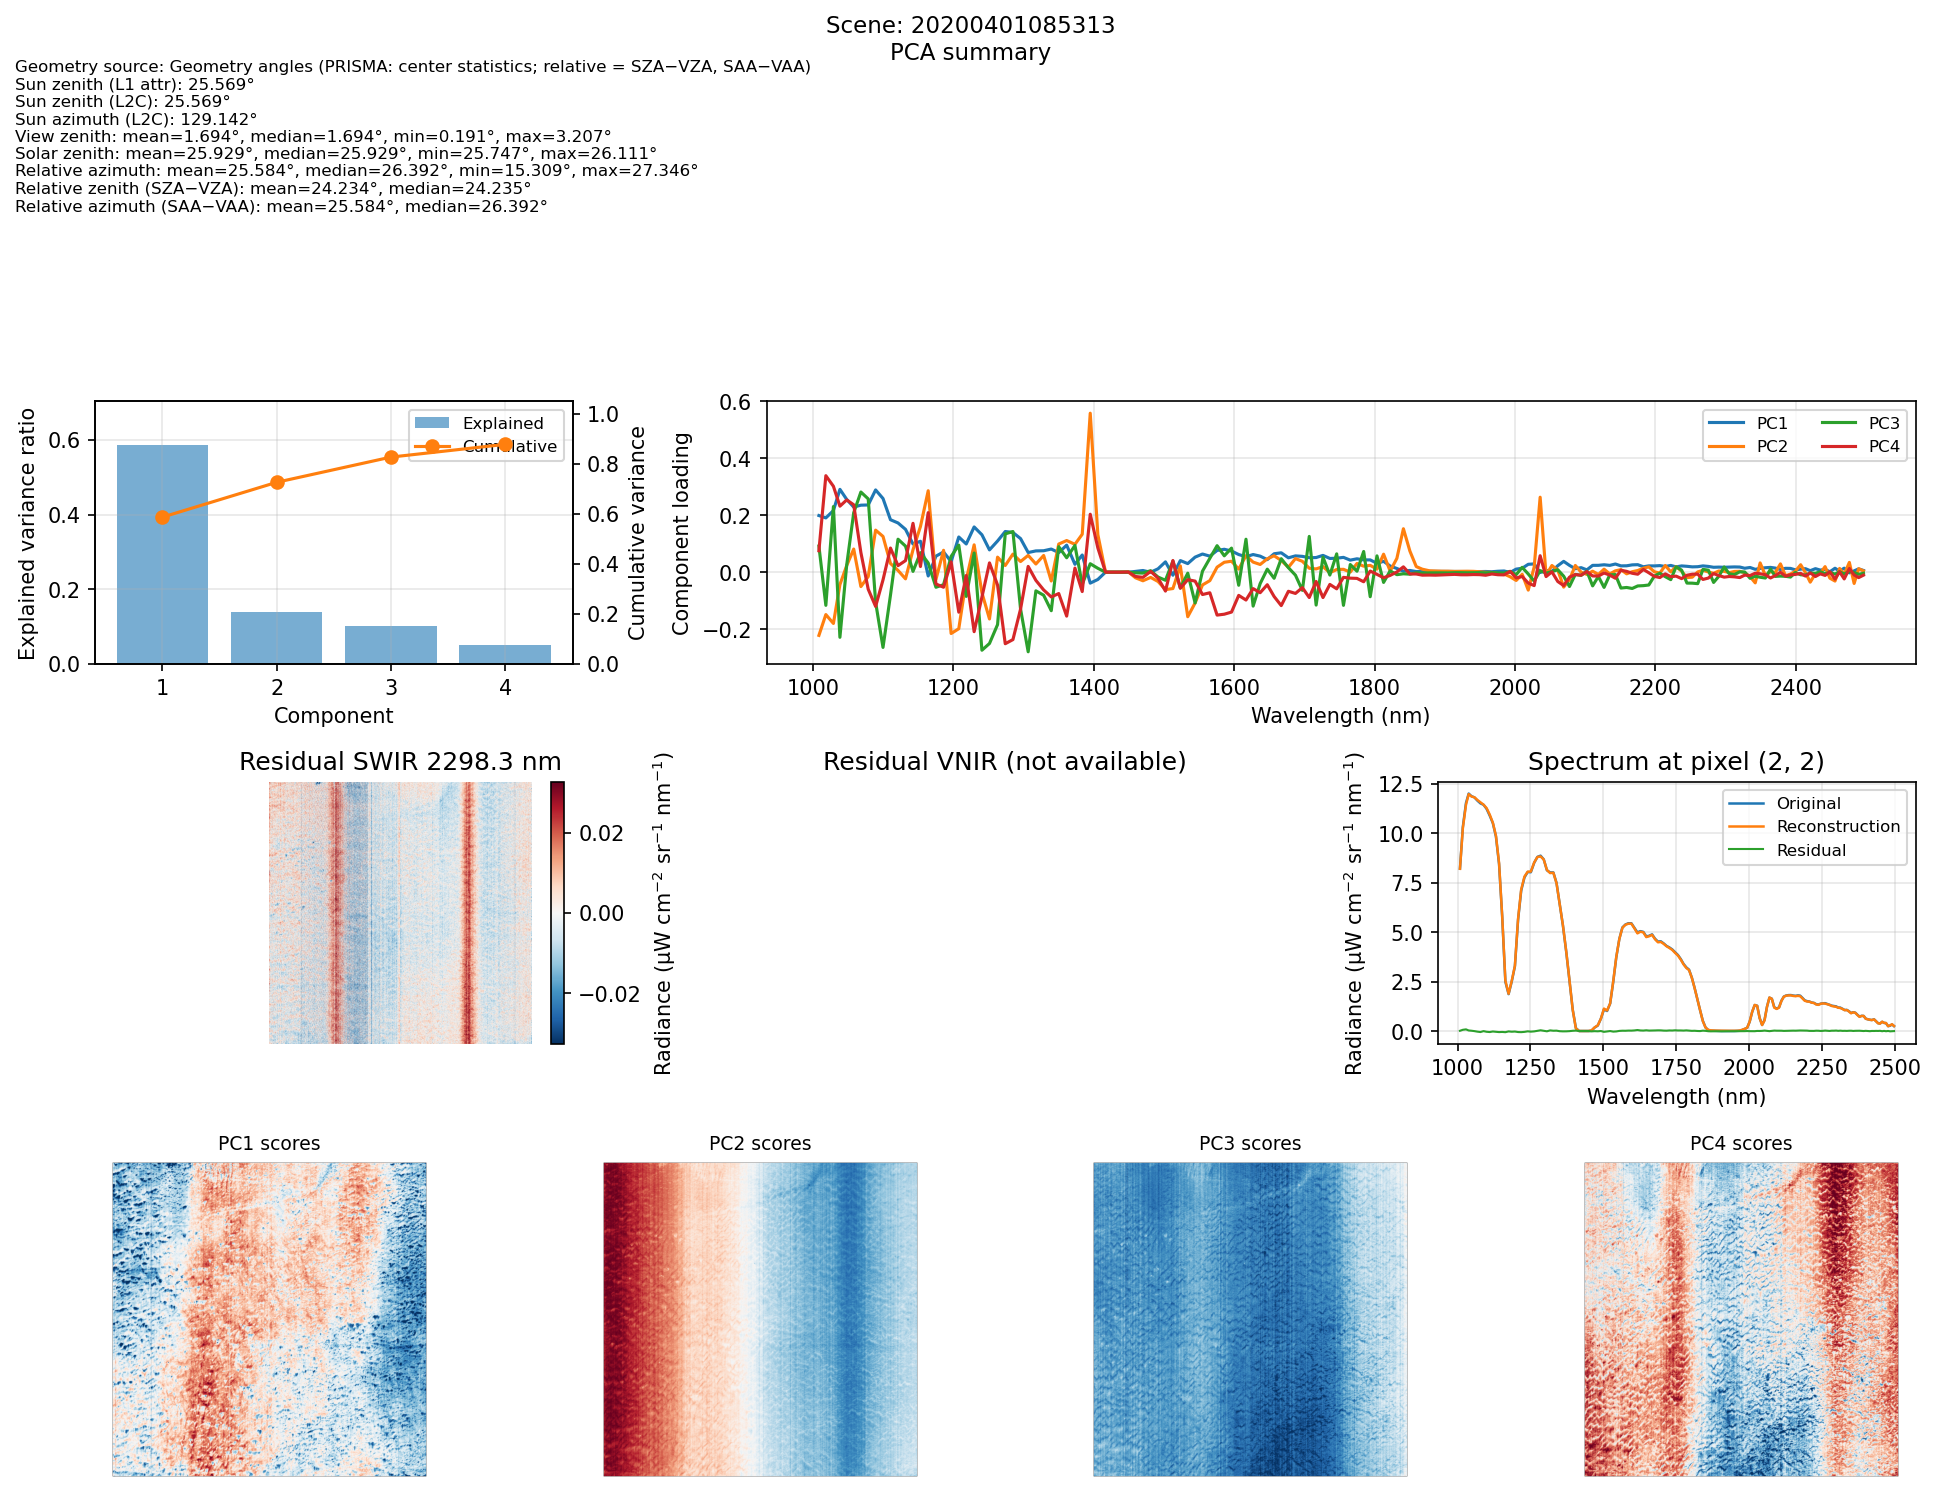

In [10]:
from glob import glob
from IPython.display import Image

output_root = (DEFAULT_OUTDIR / "prisma")
output_root.mkdir(parents=True, exist_ok=True)

if output_root.exists():
    csv_paths = sorted(output_root.glob("**/snr_cases_*.csv"))
    overview_pngs = sorted(output_root.glob("**/snr_cases_overview.png"))
    striping_pngs = sorted(output_root.glob("**/striping_diagnostics.png"))
    pca_pngs = sorted(output_root.glob("**/pca_summary_*.png"))

    display(Markdown(
        f"Found {len(csv_paths)} CSV files, {len(overview_pngs)} SNR overview plots, "
        f"{len(striping_pngs)} striping diagnostics, and {len(pca_pngs)} PCA summaries."
    ))

    if overview_pngs:
        display(Markdown("#### SNR overview"))
        for png in overview_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=str(png)))

    if striping_pngs:
        display(Markdown("#### Striping diagnostics"))
        for png in striping_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=str(png)))

    if pca_pngs:
        display(Markdown("#### PCA summaries"))
        for png in pca_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=str(png)))
else:
    display(Markdown("`outputs/prisma` directory not found yet. Run at least one experiment."))
